## PyTorch Dataset and DataLoader

In this notebook we will explore how PyTorch handles data using `Dataset` and `DataLoader`.

We’ll cover:
- The difference between `Dataset` and `DataLoader`
- How to create a custom dataset
- How to use DataLoader for batching, shuffling, and multiprocessing
- Tips and best practices

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import pandas as pd
from PIL import Image

## What is a Dataset?

A `Dataset` in PyTorch represents a collection of samples.  
You need to implement:
- `__len__`: returns the size of the dataset  
- `__getitem__`: returns one sample (given an index)


In [15]:
class SimpleDataset(Dataset):
    def __init__(self):
        self.data = torch.arange(10)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

dataset = SimpleDataset()
print("Dataset length:", len(dataset))
print("Sample [3]:", dataset[3])


Dataset length: 10
Sample [3]: tensor(3)


## What is a DataLoader?

A `DataLoader` provides an easy way to iterate over a `Dataset`:
- It supports batching
- It can shuffle data
- It can use multiple workers to speed up loading


In [16]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

for batch in dataloader:
    print(batch)

tensor([8, 0, 1, 5])
tensor([6, 9, 2, 7])
tensor([4, 3])


## Using a Real Dataset (MNIST Example)

PyTorch provides many popular datasets via `torchvision.datasets`.  
These datasets are downloaded automatically and can be easily wrapped in a `DataLoader`.

Here we’ll use the **MNIST** dataset — a collection of 28x28 grayscale images of handwritten digits (0–9).

Each sample in this dataset consists of:
- An image (`torch.Tensor` of shape `[1, 28, 28]`)
- Its corresponding label (`int`)

We’ll also apply some simple transformations to convert the image to a tensor and normalize pixel values.


In [17]:
from torchvision.datasets import MNIST

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = MNIST(
    root='data', 
    train=True, 
    download=True, 
    transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)


images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


The shapes confirm:
- `images.shape = [64, 1, 28, 28]` → 64 images, 1 channel, 28x28 pixels
- `labels.shape = [64]` → 64 corresponding digit labels

By iterating over the `train_loader`, we can feed data into a model in batches during training.

This approach automatically handles:
- Shuffling (so the model doesn’t see the same order every epoch)
- Batching (so we process multiple samples efficiently on GPU)
- Parallel loading (with `num_workers`)


## Creating a Custom Dataset

Sometimes you have your **own data**, not from torchvision — for example:
- Images stored in folders
- Metadata stored in a CSV file
- Sensor or tabular data

In these cases, you can create your own dataset by subclassing `torch.utils.data.Dataset`.

You only need to define:
- `__init__`: how your data is initialized (e.g. reading a CSV)
- `__len__`: total number of samples
- `__getitem__`: how to load and return a sample given an index


In [18]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path = f"{self.img_dir}/{self.data.iloc[idx, 0]}"
        image = Image.open(img_path)
        label = self.data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label


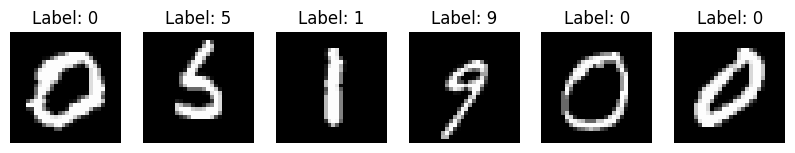

In [19]:
import matplotlib.pyplot as plt

def show_images(images, labels, n=6):
    plt.figure(figsize=(10, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()

show_images(images, labels)